In [97]:
import torch

from vision_models_playground.datasets.datasets import get_voc_detection_dataset_raw
import cv2
import numpy as np
import PIL
from typing import Dict
from typing import List, Tuple
from PIL.Image import Image

from vision_models_playground.transforms.base import TransformWithCoordsModule

In [98]:
# Get the dataset
voc_train, _ = get_voc_detection_dataset_raw(root='./../data')

In [99]:
# Grab a sample
image, target = next(iter(voc_train))

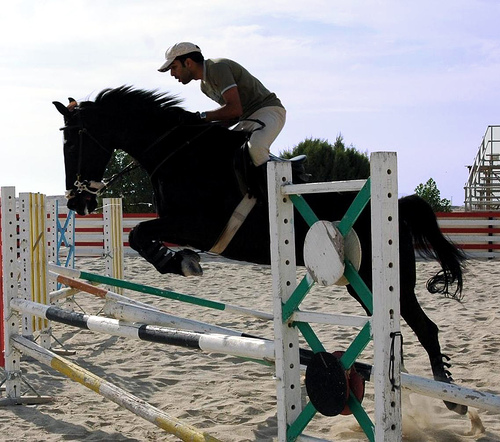

In [100]:
image

In [101]:
image.width

500

In [102]:
image.height

442

In [103]:
def extract_objects_from_target(target: Dict) -> Tuple[List[Tuple], List[str]]:
    """
    Extracts the objects from the target dictionary
    """

    bboxes = []
    classes = []
    for obj in target['annotation']['object']:
        bbox = obj['bndbox']
        x_min = int(bbox['xmin'])
        y_min = int(bbox['ymin'])
        x_max = int(bbox['xmax'])
        y_max = int(bbox['ymax'])
        class_name = obj['name']

        bboxes.append((x_min, y_min, x_max, y_max))
        classes.append(class_name)

    return bboxes, classes

In [104]:
def bboxes_to_coords(bboxes: List[Tuple[int, int, int, int]]) -> torch.Tensor:
    """
    Converts the objects to coordinates
    """
    coords = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        coords.append([x_min, y_min])
        coords.append([x_min, y_max])
        coords.append([x_max, y_min])
        coords.append([x_max, y_max])

    return torch.tensor(coords)

In [105]:
def coords_to_bboxes(coords: torch.Tensor) -> List[Tuple[int, int, int, int]]:
    """
    Converts the coordinates to objects
    """
    bboxes = []
    for i in range(0, len(coords), 4):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        x3, y3 = coords[i+2]
        x4, y4 = coords[i+3]
        x_min = min(x1, x2, x3, x4)
        y_min = min(y1, y2, y3, y4)
        x_max = max(x1, x2, x3, x4)
        y_max = max(y1, y2, y3, y4)
        bboxes.append((x_min, y_min, x_max, y_max))

    # Cast all the bboxes to int
    bboxes = [(int(x_min), int(y_min), int(x_max), int(y_max)) for x_min, y_min, x_max, y_max in bboxes]

    return bboxes

In [106]:
def draw_bboxes(image: Image, bboxes: List[Tuple[int, int, int, int]], classes: List[str]) -> Image:
    """
    Draws the bounding boxes on the image
    """
    image_edited = np.array(image)
    for bbox, class_name in zip(bboxes, classes):
        # set random seed
        np.random.seed(0)
        color = np.random.randint(0, 255, 3).tolist()
        x_min, y_min, x_max, y_max = bbox

        cv2.rectangle(image_edited, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image_edited, class_name, (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    return PIL.Image.fromarray(image_edited)

In [107]:
bboxes, classes = extract_objects_from_target(target)

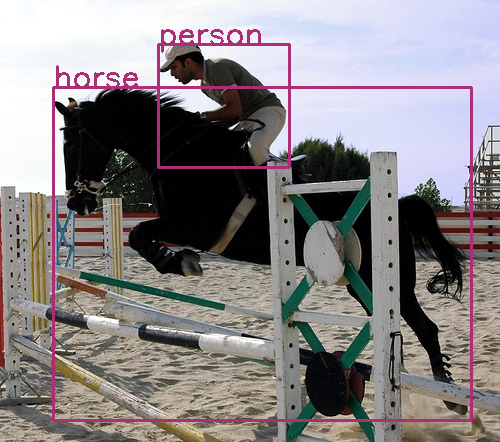

In [108]:
draw_bboxes(image, bboxes, classes)

In [109]:
def torch_to_pil(image: torch.Tensor) -> Image:
    """
    Converts a torch tensor to a PIL image
    """
    return PIL.Image.fromarray((image.permute(1, 2, 0) * 255).numpy().astype(np.uint8))

In [110]:
import torchvision.transforms.functional as F

def apply_transforms(image: Image, target: Dict, transform: TransformWithCoordsModule) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Applies the transforms to the image and target
    """
    # Convert the image to a tensor
    image = F.to_tensor(image)

    # Convert the target to a tensor
    bboxes, classes = extract_objects_from_target(target)
    coords = bboxes_to_coords(bboxes)

    # Apply the transforms
    image, coords = transform(image, coords)

    # Convert the image back to a PIL image
    image = torch_to_pil(image)

    # Convert the coords back to objects
    bboxes = coords_to_bboxes(coords)

    # Draw the bounding boxes
    image = draw_bboxes(image, bboxes, classes)

    return image

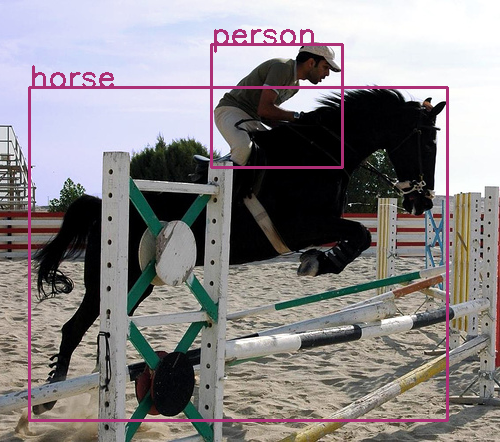

In [111]:
from vision_models_playground.transforms.random_horizontal_flip import RandomHorizontalFlipWithCoords

transform = RandomHorizontalFlipWithCoords(p=1.0)
apply_transforms(image, target, transform)

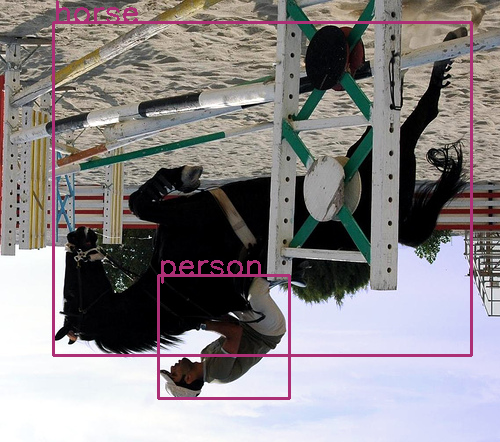

In [112]:
from vision_models_playground.transforms.random_vertical_flip import RandomVerticalFlipWithCoords

transform = RandomVerticalFlipWithCoords(p=1.0)
apply_transforms(image, target, transform)

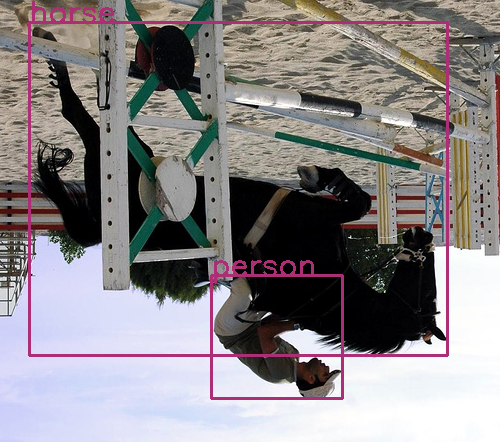

In [113]:
from vision_models_playground.transforms.compose import ComposeWithCoords

transform = ComposeWithCoords([
    RandomHorizontalFlipWithCoords(p=1.0),
    RandomVerticalFlipWithCoords(p=1.0)
])

apply_transforms(image, target, transform)

[250.0, 221.0]


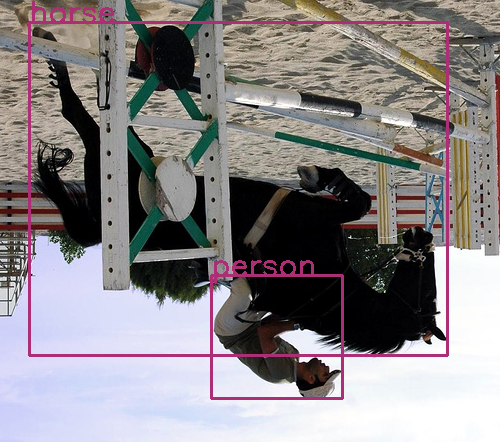

In [114]:
from vision_models_playground.transforms.random_rotation import RandomRotationWithCoords

transform = RandomRotationWithCoords(degrees=(180, 180))
apply_transforms(image, target, transform)

[250.0, 221.0]


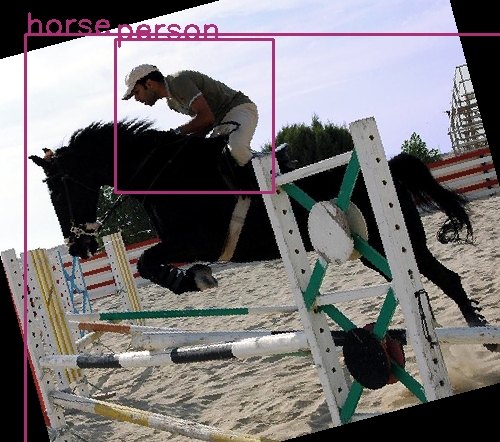

In [115]:
transform = RandomRotationWithCoords(degrees=(15, 15))
apply_transforms(image, target, transform)

[250.0, 221.0]


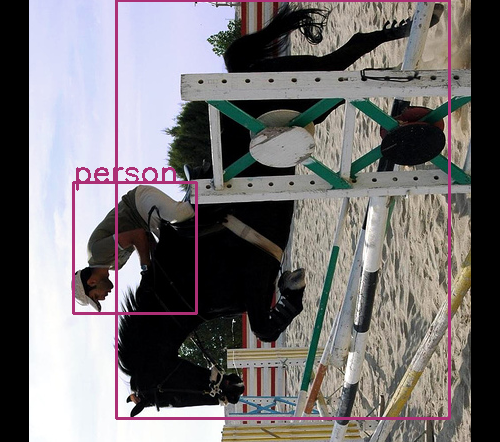

In [116]:
transform = RandomRotationWithCoords(degrees=(90, 90))
apply_transforms(image, target, transform)

[250.0, 221.0]


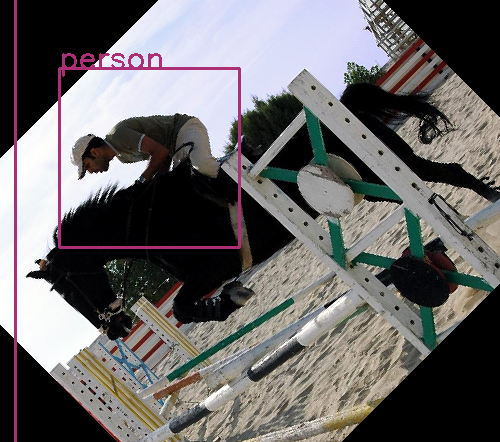

In [117]:
transform = RandomRotationWithCoords(degrees=(45, 45))
apply_transforms(image, target, transform)